### Notes on Template Matching

There are a variety of methods to perform template matching, but in this case we are using the correlation coefficient which is specified by the flag **cv2.TM_CCOEFF.**

So what exactly is the cv2.matchTemplate function doing?
Essentially, this function takes a “sliding window” of our waldo query image and slides it across our puzzle image from left to right and top to bottom, one pixel at a time. Then, for each of these locations, we compute the correlation coefficient to determine how “good” or “bad” the match is. 

Regions with sufficiently high correlation can be considered “matches” for our waldo template.
From there, all we need is a call to cv2.minMaxLoc on Line 22 to find where our “good” matches are.
That’s really all there is to template matching!

http://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html      

In [1]:
import cv2
import numpy as np

# Load input image and convert to grayscale
image = cv2.imread('./images/WaldoBeach.jpg')
cv2.imshow('Where is Waldo?', image)
cv2.waitKey(0)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Load Template image
template = cv2.imread('./images/waldo.jpg',0)

result = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

#Create Bounding Box
top_left = max_loc
bottom_right = (top_left[0] + 50, top_left[1] + 50)
cv2.rectangle(image, top_left, bottom_right, (0,0,255), 5)

cv2.imshow('Where is Waldo?', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Finding Corners

#### Harris Corner Detection is an algorithm developed in 1998 for corner detection  (http://www.bmva.org/bmvc/1988/avc-88-023.pdf) and works fairly well.

**cv2.cornerHarris**(input image, block size, ksize, k)
- Input image - should be grayscale and float32 type.
- blockSize - the size of neighborhood considered for corner detection
- ksize - aperture parameter of Sobel derivative used.
- k - harris detector free parameter in the equation
- **Output** – array of corner locations (x,y)




In [2]:
import cv2
import numpy as np

# Load image then grayscale
image = cv2.imread('images/chess.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# The cornerHarris function requires the array datatype to be float32
gray = np.float32(gray)

harris_corners = cv2.cornerHarris(gray, 3, 3, 0.05)

#We use dilation of the corner points to enlarge them\
kernel = np.ones((7,7),np.uint8)
harris_corners = cv2.dilate(harris_corners, kernel, iterations = 2)

# Threshold for an optimal value, it may vary depending on the image.
image[harris_corners > 0.025 * harris_corners.max() ] = [255, 127, 127]

cv2.imshow('Harris Corners', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Improved Corner Detection using - Good Features to Track

**cv2.goodFeaturesToTrack**(input image, maxCorners, qualityLevel, minDistance)

- Input Image - 8-bit or floating-point 32-bit, single-channel image.
- maxCorners – Maximum number of corners to return. If there are more corners than are found, the strongest of them is returned.
- qualityLevel – Parameter characterizing the minimal accepted quality of image corners. The parameter value is multiplied by the best corner quality measure (smallest eigenvalue). The corners with the quality measure less than the product are rejected. For example, if the best corner has the quality measure = 1500, and the  qualityLevel=0.01 , then all the corners with the quality - - measure less than 15 are rejected.
- minDistance – Minimum possible Euclidean distance between the returned corners.


In [3]:
import cv2
import numpy as np

img = cv2.imread('images/chess.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# We specific the top 50 corners
corners = cv2.goodFeaturesToTrack(gray, 100, 0.01, 150)

for corner in corners:
    x, y = corner[0]
    x = int(x)
    y = int(y)
    cv2.rectangle(img,(x-10,y-10),(x+10,y+10),(0,255,0), 2)
    
cv2.imshow("Corners Found", img)
cv2.waitKey()
cv2.destroyAllWindows()

## Oriented FAST and Rotated BRIEF (ORB)
http://www.willowgarage.com/sites/default/files/orb_final.pdf

In [4]:
import cv2
import numpy as np

image = cv2.imread('images/input.jpg')
cv2.imshow('Original', image)
cv2.waitKey()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create ORB object, we can specify the number of key points we desire
orb = cv2.ORB_create()

# Determine key points
keypoints, descriptors = orb.detectAndCompute(gray, None)

# Obtain the descriptors
#keypoints, descriptors = orb.compute(gray, keypoints)
print("Number of keypoints Detected: ", len(keypoints))

# Draw rich keypoints on input image
image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('Feature Method - ORB', image)
cv2.waitKey()
cv2.destroyAllWindows()

Number of keypoints Detected:  500


## Histogram of Oriented Gradients

- http://stackoverflow.com/questions/6090399/get-hog-image-features-from-opencv-python
- http://www.juergenwiki.de/work/wiki/doku.php?id=public:hog_descriptor_computation_and_visualization

### NOTE:
Run this following block of code twice of the graphs to be displayed!

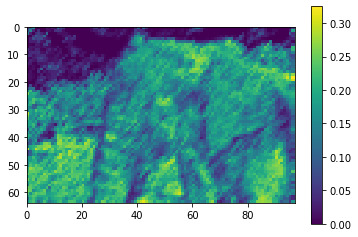

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image then grayscale
image = cv2.imread('images/elephant.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Show original Image
cv2.imshow('Input Image', image)
cv2.waitKey(0)

# h x w in pixels
cell_size = (8, 8) 

 # h x w in cells
block_size = (2, 2) 

# number of orientation bins
nbins = 9

# Using OpenCV's HOG Descriptor
# winSize is the size of the image cropped to a multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(gray.shape[1] // cell_size[1] * cell_size[1],
                                  gray.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

# Create numpy array shape which we use to create hog_feats
n_cells = (gray.shape[0] // cell_size[0], gray.shape[1] // cell_size[1])

# We index blocks by rows first.
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.
hog_feats = hog.compute(gray).reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins).transpose((1, 0, 2, 3, 4))  

# Create our gradients array with nbin dimensions to store gradient orientations 
gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# Create array of dimensions 
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

# Block Normalization
for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                  off_x:n_cells[1] - block_size[1] + off_x + 1] += \
            hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                   off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count

# Plot HOGs using Matplotlib
# angle is 360 / nbins * direction
color_bins = 5
plt.pcolor(gradients[:, :, color_bins])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()
cv2.destroyAllWindows()